# Environment setup


In [1]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Copy the dataset from Google Drive to local

!cp "/content/gdrive/My Drive/CBIS_DDSM.zip" .
!unzip -qq CBIS_DDSM.zip
!rm CBIS_DDSM.zip
cbis_path = 'CBIS_DDSM'

In [4]:
# Import libraries
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.utils import plot_model


# Data Preprocess


In [5]:
def load_training():
    """
    Load the training set
    """
    abnorm_patches = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    base_patches = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[0::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return abnorm_patches, base_patches, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    abnorm_patches = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    base_patches = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[0::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return abnorm_patches, base_patches, labels


def remap_label(l):
    """
    Remap the labels to 0->mass 1->calcification
    """
    if l == 1 or l == 2:
        return 0
    elif l == 3 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [6]:
# Load training and test images (abnormalities only, no baseline)
train_abn_images, train_base_images, train_labels= load_training()
test_abn_images, test_base_images, test_labels= load_testing()

# Number of images
n_train_img = train_abn_images.shape[0]
n_test_img = test_abn_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_abn_images.shape[1]
img_h = train_abn_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Create a new dimension for color in the images arrays
train_abn_images = train_abn_images.reshape((n_train_img, img_w, img_h, 1))
train_base_images = train_base_images.reshape((n_train_img, img_w, img_h, 1))
test_abn_images = test_abn_images.reshape((n_test_img, img_w, img_h, 1))
test_base_images = test_base_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_abn_images = train_abn_images.astype('uint16') / 65535
train_base_images = train_base_images.astype('uint16') / 65535
test_abn_images = test_abn_images.astype('uint16') / 65535
test_base_images = test_base_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_abn_images = train_abn_images[perm]
train_base_images = train_base_images[perm]
train_labels = train_labels[perm]

def double_generator(train_abn_images, train_base_images, train_labels, subset, batch_size=128):

    gen = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=180,
        shear_range=15,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect'
    )

    gen.fit(train_abn_images)

    gen_abn = gen.flow(train_abn_images, train_labels,  batch_size=batch_size, subset=subset, seed=1)
    gen_base = gen.flow(train_base_images, train_labels, batch_size=batch_size, subset=subset, seed=1)

    while True:
        abn_img, abn_label = gen_abn.next()
        base_img, _ = gen_base.next()
        yield [abn_img, base_img], abn_label


train_generator = double_generator(train_abn_images, train_base_images, train_labels, 'training', batch_size=128)
validation_generator = double_generator(train_abn_images, train_base_images, train_labels, 'validation', batch_size=128)

Train size: 2676 	 Test size: 336
Image size: 150x150


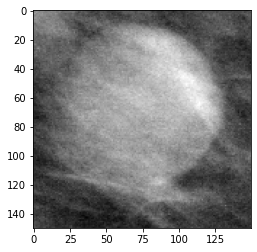

Label: 0


In [7]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_abn_images[idx][:,:,0], cmap='gray')
plt.show()


print("Label: " + str(train_labels[idx]))

# Siamese Network

In [8]:
''' Create a Siamese network '''

def create_siamese():

    # Two input channels
    left_input = layers.Input(shape=(150, 150, 1))
    right_input = layers.Input(shape=(150, 150, 1))

    # CNN core
    cnn = models.Sequential()
    cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1), name="Conv_Layer_1"))
    cnn.add(layers.MaxPooling2D((2, 2), name="MaxPool_Layer_1"))
    cnn.add(layers.Conv2D(64, (3, 3), activation='relu', name = "Conv_layer_2"))
    cnn.add(layers.MaxPooling2D((2, 2), name= "MaxPool_Layer_2"))
    cnn.add(layers.Conv2D(128, (3, 3), activation='relu', name= "Conv_Layer_3"))
    cnn.add(layers.MaxPooling2D((2, 2), name="MaxPool_layer_3"))
    cnn.add(layers.Flatten())

    # Feed both input into the same convolutional base
    left_model = cnn(left_input)
    right_model = cnn(right_input)

    # Compute the difference between the two
    diff = layers.Subtract()([left_model, right_model])

    # FC layer
    fc = layers.Flatten()(diff)
    fc = layers.Dense(96, activation="relu")(fc)
    fc = layers.Dropout(0.5)(fc)
    fc = layers.Dense(1, activation="sigmoid")(fc)

    # Instantiate the model
    siamese = models.Model(inputs=[left_input, right_input], outputs=fc)

    return siamese

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 36992)        92672       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
subtract (Subtract)             (None, 36992)        0           sequential[0][0]      

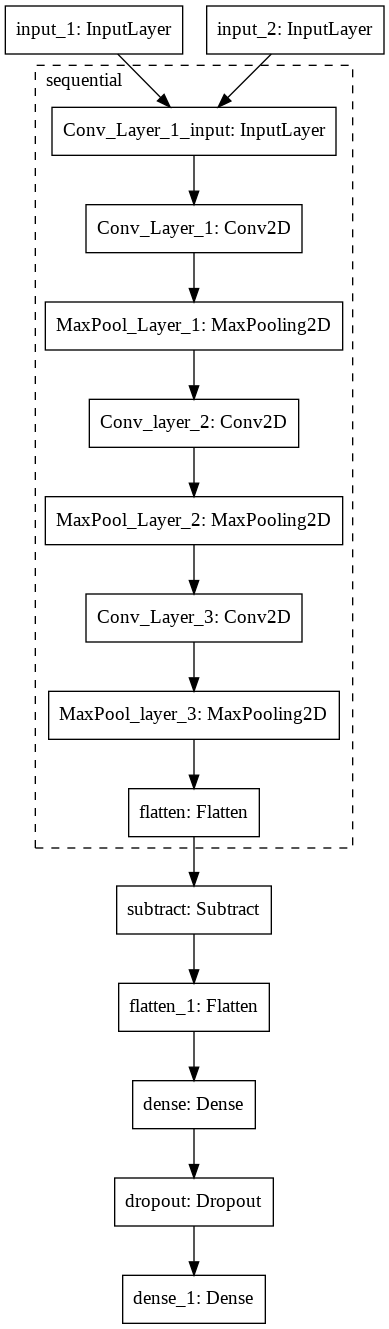

In [ ]:
siamese_example = create_siamese()
siamese_example.summary()
plot_model(siamese_example, expand_nested=True)       
!cp "/root/model.png" -r "/content/gdrive/My Drive/models/model_siamese.png"       
from IPython.display import Image
Image(filename='model.png')                        

# Run Model


In [ ]:
# Create model
siamese = create_siamese()

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('siamese_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
siamese.compile(optimizer= Adam(learning_rate=0.001,epsilon=1e-7), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_siamese = siamese.fit(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        validation_steps = int(0.2*n_train_img) // 128,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save file to drive
siamese.save( 'siamese_end.h5')
!cp "/root/siamese_best.h5" -r "/content/gdrive/My Drive/models/siamese_best.h5"


Epoch 1/500
16/16 [==============================] - 44s 585ms/step - loss: 0.6789 - accuracy: 0.5983 - val_loss: 0.6361 - val_accuracy: 0.7012

Epoch 00001: val_loss improved from inf to 0.63615, saving model to siamese_best.h5
Epoch 2/500
16/16 [==============================] - 9s 529ms/step - loss: 0.6416 - accuracy: 0.6720 - val_loss: 0.5951 - val_accuracy: 0.7051

Epoch 00002: val_loss improved from 0.63615 to 0.59515, saving model to siamese_best.h5
Epoch 3/500
16/16 [==============================] - 8s 539ms/step - loss: 0.6095 - accuracy: 0.7132 - val_loss: 0.5531 - val_accuracy: 0.7539

Epoch 00003: val_loss improved from 0.59515 to 0.55306, saving model to siamese_best.h5
Epoch 4/500
16/16 [==============================] - 8s 539ms/step - loss: 0.6222 - accuracy: 0.7140 - val_loss: 0.5605 - val_accuracy: 0.7559

Epoch 00004: val_loss did not improve from 0.55306
Epoch 5/500
16/16 [==============================] - 8s 543ms/step - loss: 0.5946 - accuracy: 0.7178 - val_loss:

# Evaluate Model

In [ ]:
# History of accuracy and loss
training_loss = history_siamese.history['loss']
training_accuracy = history_siamese.history['accuracy']
validation_loss = history_siamese.history['val_loss']
validation_accuracy = history_siamese.history['val_accuracy']

# Total number of epochs training
epochs = range(1, len(training_accuracy)+1)
end_epoch = len(training_accuracy)

# Validation loss minimum epoch(optimal)
optimal_epoch = validation_loss.index(min(validation_loss)) + 1

# Loss and accuracy on the validation set
end_validation_loss = validation_loss[-1]
end_validation_accuracy = validation_accuracy[-1]
optimal_validation_loss = validation_loss[optimal_epoch-1]
optimal_validation_accuracy = validation_accuracy[optimal_epoch-1]

# Loss and accuracy on the test set
optimal_siamese = models.load_model('siamese_best.h5')
test_loss, test_accuracy = siamese.evaluate([test_abn_images, test_base_images], test_labels, verbose=False)
optimal_test_loss, optimal_test_accuracy = optimal_siamese.evaluate([test_abn_images, test_base_images], test_labels, verbose=False)

print("Siamese Network\n")

print("Epoch [end]: %d" % end_epoch)
print("Epoch [opt]: %d" % optimal_epoch)
print("Valid accuracy [end]: %.4f" % end_validation_accuracy)
print("Valid accuracy [opt]: %.4f" % optimal_validation_accuracy)
print("Test accuracy [end]:  %.4f" % test_accuracy)
print("Test accuracy [opt]:  %.4f" % optimal_test_accuracy)
print("Valid loss [end]: %.4f" % end_validation_loss)
print("Valid loss [opt]: %.4f" % optimal_validation_loss)
print("Test loss [end]:  %.4f" % test_loss)
print("Test loss [opt]:  %.4f" % optimal_test_loss)

Siamese Network

Epoch [end]: 500
Epoch [opt]: 484
Valid accuracy [end]: 0.8848
Valid accuracy [opt]: 0.8730
Test accuracy [end]:  0.8810
Test accuracy [opt]:  0.8661
Valid loss [end]: 0.2799
Valid loss [opt]: 0.2796
Test loss [end]:  0.3010
Test loss [opt]:  0.3180


In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=100, facecolor='w', edgecolor='k')
plt.title('Siamese accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs, training_accuracy, 'r', label='Training set')
plt.plot(epochs, validation_accuracy, 'b', label='Validation set')
plt.plot(optimal_epoch, validation_accuracy[optimal_epoch-1], 'go')
plt.vlines(optimal_epoch, min(validation_accuracy), optimal_validation_accuracy, linestyle="dashed", color='b', linewidth=1)
plt.hlines(optimal_validation_accuracy, 1, optimal_epoch, linestyle="dashed", color='b', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=100, facecolor='w', edgecolor='k')
plt.title('Siamese loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs, training_loss, 'r', label='Training set')
plt.plot(epochs, validation_loss, 'b', label='Validation set')
plt.plot(optimal_epoch, validation_loss[optimal_epoch-1], 'go')
plt.vlines(optimal_epoch, min(validation_loss), optimal_validation_loss, linestyle="dashed", color='b', linewidth=1)
plt.hlines(optimal_validation_loss, 1, optimal_epoch, linestyle="dashed", color='b', linewidth=1)
plt.legend();

NameError: ignored

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

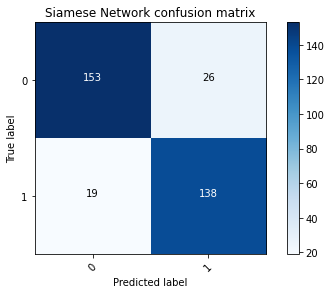

In [ ]:
pred = optimal_siamese.predict([test_abn_images, test_base_images])

pred_classes = np.rint(pred)
confusion_mtx = confusion_matrix(test_labels, pred_classes) 
plot_confusion_matrix(confusion_mtx, classes=range(2), normalize=False, title='Siamese Network confusion matrix')

In [ ]:
def plot_roc(preds, names, titles='ROC curve'):
    plt.figure(figsize=(10, 8), dpi=180, facecolor='w', edgecolor='k')
    for pred, name in zip(preds, names):
        fpr, tpr, _ = roc_curve(test_labels, pred)
        auc_keras = auc(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label=(name +' (area = {:.3f})'.format(auc_keras)))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()

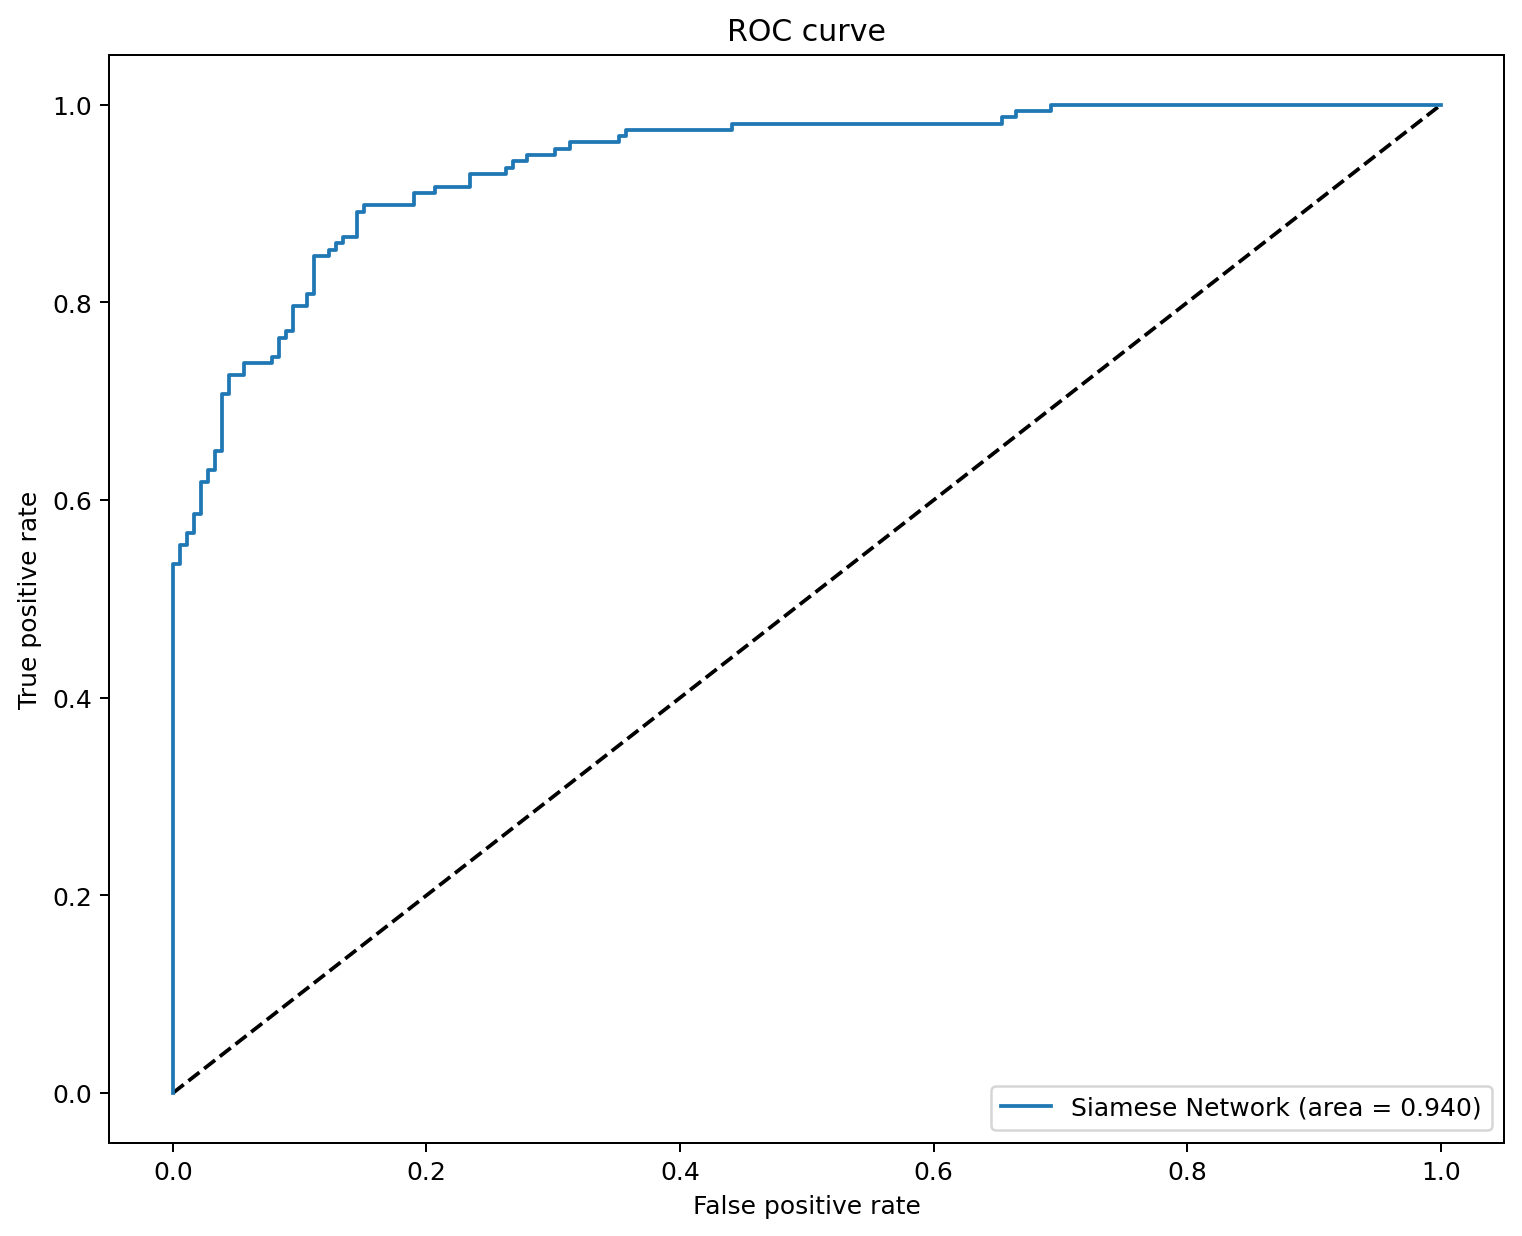

In [ ]:
plot_roc([pred], names=['Siamese Network'])

In [ ]:
# Classification report

print(classification_report(test_labels, pred_classes, digits=4))

              precision    recall  f1-score   support

           0     0.8895    0.8547    0.8718       179
           1     0.8415    0.8790    0.8598       157

    accuracy                         0.8661       336
   macro avg     0.8655    0.8669    0.8658       336
weighted avg     0.8671    0.8661    0.8662       336

